# Neural Network Training

In [40]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Importing 4 Seasons of NBA Data (2020-2024)

In [2]:
season_20 = pd.read_csv('../data_generation/output_data/2020-21_data.csv')
season_21 = pd.read_csv('../data_generation/output_data/2021-22_data.csv')
season_22 = pd.read_csv('../data_generation/output_data/2022-23_data.csv')
season_23 = pd.read_csv('../data_generation/output_data/2023-24_data.csv')

combined_seasons = pd.concat([season_20, season_21, season_22, season_23], ignore_index=True)
combined_season = combined_seasons.drop_duplicates()
combined_seasons = combined_seasons.reset_index(drop=True)

# combined_seasons.head(10)

## Prepare features and target value

In [73]:
# Drop target and prepare input
input = combined_seasons.drop(columns=['PTS'])
target = combined_seasons['PTS']

# Load selected features
spearman_corr = pd.read_csv('../data_generation/output_data/spearman_corr_features.csv')
selected_features = spearman_corr['Feature'].tolist()
selected_features.append('teamId')

# Ensure no mismatching features
existing_features = [feature for feature in selected_features if feature in input.columns]

# Filter for Boston Celtics data for testing
bos_team_id = 1610612738
boston_data = combined_seasons[combined_seasons['teamId'] == bos_team_id]

existing_features.remove('teamId')

# Create input_test and target_test specifically for Boston Celtics
input_test_bos = boston_data[existing_features]
target_test_bos = boston_data['PTS']

# Create input for general model
input = combined_seasons[existing_features]
input = input.dropna(axis=1)
print(input.info())  # 126 cols, 9540 rows

# Split into train and test set
input_train, input_test, target_train, target_test = train_test_split(input, target, test_size=0.2, random_state=0)

# Scale features
scaler = StandardScaler()
input_train = scaler.fit_transform(input_train)
input_test = scaler.transform(input_test)

input_test_bos = scaler.fit_transform(input_test_bos)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9540 entries, 0 to 9539
Columns: 126 entries, fieldGoalPercentage_my_player_1 to OPPONENT_WIN_PCT
dtypes: float64(123), int64(3)
memory usage: 9.2 MB
None


## Define the model

In [74]:
# Initialize sequential model 
model = Sequential([
    Input(shape=(input_train.shape[1],)), # define input shape
    Dense(64, activation='relu'), # first hidden layer with 64 units
    Dropout(0.2), 
    Dense(32, activation='relu'), # second hidden layer with 32 units
    Dense(1) # Output layer with target (PTS)
])

# Compile the model 
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(input_train, target_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9942.1543 - mae: 96.0049 - val_loss: 631.8538 - val_mae: 20.1114
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 715.1095 - mae: 21.6209 - val_loss: 461.4369 - val_mae: 17.1420
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 575.3356 - mae: 19.2688 - val_loss: 392.7081 - val_mae: 15.9652
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 489.3665 - mae: 17.7950 - val_loss: 339.5015 - val_mae: 14.6713
Epoch 5/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 433.5749 - mae: 16.6905 - val_loss: 309.4973 - val_mae: 14.0419
Epoch 6/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 395.5538 - mae: 15.9793 - val_loss: 281.3827 - val_mae: 13.4423
Epoch 7/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 358.4023 - mae: 15.1339 - val_loss: 260.8256 - val_mae: 12.9281
Epoch 8/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 328.3441 - mae: 14.5974 - val_loss: 239.2593 - val_mae: 12.2637
Epoch

## Visualize History

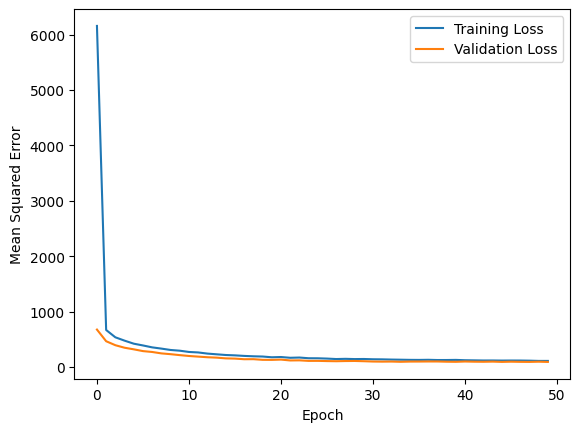

In [63]:
# Plot training and validation loss over epochs
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

## General Model Evaluation and Sample Target Prediction

In [77]:
# Evaluate model on test data
test_loss, test_mae = model.evaluate(input_test, target_test)
print(f"Test Loss (MSE): {test_loss}")
print(f"Test MAE: {test_mae}")

# Target prediction
sample_predictions = model.predict(input_test)
print("Sample Predictions (PTS):", sample_predictions[:10].flatten())
print("Actual Vales (PTS):", target_test[:10].values)

mse = mean_squared_error(target_test, sample_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(target_test, sample_predictions)

print("\n--- Regression Metrics ---")
print(f"Test Loss (MSE from model): {test_loss:.2f}")
print(f"Test MAE (from model): {test_mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-Squared (R²): {r2:.2f}")

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 91.4050 - mae: 7.5684  
Test Loss (MSE): 91.53682708740234
Test MAE: 7.57977819442749
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step
Sample Predictions (PTS): [102.91417  107.086266 116.80001  112.972466 107.877205 102.63116
 103.70132  103.146706 107.87088  113.70305 ]
Actual Vales (PTS): [122 123 127 100 111  92  86 123 114 122]

--- Regression Metrics ---
Test Loss (MSE from model): 91.54
Test MAE (from model): 7.58
Mean Squared Error (MSE): 91.54
Root Mean Squared Error (RMSE): 9.57
R-Squared (R²): 0.43


### Results from the Model Trained Specifically on Boston Celtics Data

#### Regression Metrics
- **Test Loss (MSE from model):** 713.21  
- **Test MAE (from model):** 21.63  
- **Mean Squared Error (MSE):** 713.21  
- **Root Mean Squared Error (RMSE):** 26.71  
- **R-Squared (R²):** -2.67  

#### Sample Predictions vs. Actual Values
| Prediction (PTS) | Actual (PTS) |
|------------------|--------------|
| 120.49           | 119          |
| 114.38           | 133          |
| 72.36            | 119          |
| 128.17           | 132          |
| 94.97            | 142          |
| 95.54            | 143          |
| 125.48           | 119          |
| 96.15            | 123          |
| 94.50            | 117          |
| 95.56            | 106          |


## Evaluation of General Model on Boston Celctics Target Prediction

In [79]:
# Evaluate model and test data
# print("input_test_bos shape:", input_test_bos.shape)
# print("target_test_bos shape:", target_test_bos.shape)

test_loss, test_mae = model.evaluate(input_test_bos, target_test_bos)

# Target prediction
bos_predictions = model.predict(input_test_bos)

mse = mean_squared_error(target_test_bos, bos_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(target_test_bos, bos_predictions)

print("Sample Prediction (PTS):", bos_predictions[:10].flatten())
print("Actual Values (PTS):", target_test_bos[:10].values)

print("\n--- Regression Metrics ---")
print(f"Test Loss (MSE from model): {test_loss:.2f}")
print(f"Test MAE (from model): {test_mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-Squared (R²): {r2:.2f}")

bos_results = pd.DataFrame({
    "Actual PTS": target_test,
    "Predicted PTS": sample_predictions.flatten()
})
bos_results.to_csv("gen_model_boston_celtics_eval.csv", index=False)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 94.3547 - mae: 7.6993
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step
Sample Prediction (PTS): [108.32346   95.374825 115.88532  106.8487   121.9682   118.78492
 124.14408  107.94017  102.95487  116.07684 ]
Actual Values (PTS): [122  95 107 116 126  93 122 126 107 116]

--- Regression Metrics ---
Test Loss (MSE from model): 106.62
Test MAE (from model): 8.34
Mean Squared Error (MSE): 106.62
Root Mean Squared Error (RMSE): 10.33
R-Squared (R²): 0.40


## Comparison of Boston Celtics-Trained Model vs. General Model Tested on Boston Celtics Data

#### Boston Celtics-Trained Model Metrics
- **Test Loss (MSE from model):** 713.21  
- **Test MAE (from model):** 21.63  
- **Mean Squared Error (MSE):** 713.21  
- **Root Mean Squared Error (RMSE):** 26.71  
- **R-Squared (R²):** -2.67  

#### General Model Tested on Boston Celtics Data Metrics
- **Test Loss (MSE from model):** 106.62  
- **Test MAE (from model):** 8.34  
- **Mean Squared Error (MSE):** 106.62  
- **Root Mean Squared Error (RMSE):** 10.33  
- **R-Squared (R²):** 0.40  

#### Sample Predictions vs. Actual Values
| **Celtics-Trained Model Predictions (PTS)** | **Celtics Actual Values (PTS)** | **General Model Predictions (PTS)** | **Celtics Actual Values (PTS)** |
|---------------------------------------------|---------------------------------|-------------------------------------|---------------------------------|
| 120.49                                      | 119                             | 108.32                              | 122                             |
| 114.38                                      | 133                             | 95.37                               | 95                              |
| 72.36                                       | 119                             | 115.89                              | 107                             |
| 128.17                                      | 132                             | 106.85                              | 116                             |
| 94.97                                       | 142                             | 121.97                              | 126                             |
| 95.54                                       | 143                             | 118.78                              | 93                              |
| 125.48                                      | 119                             | 124.14                              | 122                             |
| 96.15                                       | 123                             | 107.94                              | 126                             |
| 94.50                                       | 117                             | 102.95                              | 107                             |
| 95.56                                       | 106                             | 116.08                              | 116                             |
